# Final Project Report
### *Solving the N-Body Problem Numerically Using a Lagrangian Approach*

**Author:** Xander Carroll    
**Course:** Physics 5300, Autumn 2025  
**Date:** December 12, 2025

**Project Repository:** [Link](https://github.com/Xander-Carroll/PHYSICS5300-NBody-Final)

---

## 0. Library Imports

In [1]:
# Standard library includes
import sys

# External library includes
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# Print version information
from numpy import __version__ as np_version
from manim import __version__ as mn_version
from matplotlib import __version__ as mpl_version

print(f"python version: {sys.version}")
print(f"numpy version: {np_version}")
print(f"manim version: {mn_version}")
print(f"matplotlib version: {mpl_version}")

python version: 3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13) [MSC v.1929 64 bit (AMD64)]
numpy version: 2.1.3
manim version: 0.19.1
matplotlib version: 3.10.7


---

## 1. Physical Problem

### A. Project Proposal

I will build a numerical solver for the N-Body gravitational problem. I will implement a timestep integrator such as leapfrog, verify the behavior on simple systems (e.g., two-body orbits), and then run larger simulations to examine stability and emergent structure. If time allows, I would like to examine the problem for large values of N (~$10^4$ bodies). The resulting trajectories will be visualized using Manim or a similar animation tool. All code, animations, and documentation will be organized in a GitHub repository. There are a large number of resources (papers and pre-existing projects) for this problem. There is also great documentation for the python libraries we have been using.

### B. Describe the System

Each body will be described by a mass, position, and velocity. The position and velocity will be represented as vectors relative to an arbitrary origin using arbitrary coordinate axes.

A sketch of this system for three bodies is generated by the following code snippet. Each body has a mass $m_i$. The $\mathbf{r}_i$ vectors show the position of each body and the $\dot{\mathbf{r}}_i$ vectors show the velocity of each body. While the sketch is shown in two-dimensions, the same description can be used for three-dimensional cases.

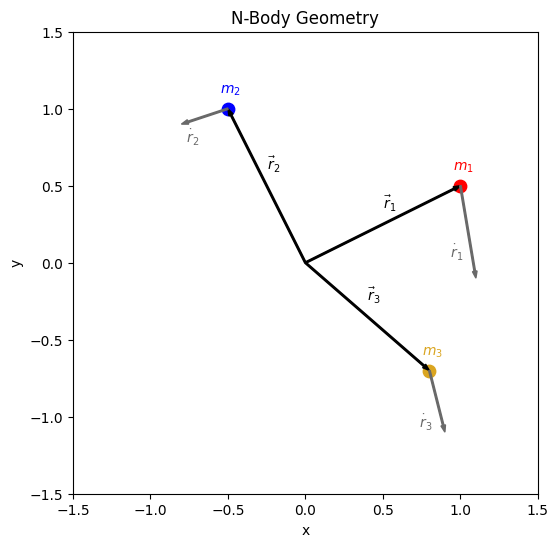

In [3]:
## Code to generate descriptive plot.

# The bodies to plot.
r = np.array([[1.0, 0.5], [-0.5, 1.0], [0.8, -0.7]])
v = np.array([[0.1, -0.6], [-0.3, -0.1], [0.1, -0.4]])
colors = ['red', 'blue', 'goldenrod']

# Create the plot.
fig, ax = plt.subplots(figsize=(6,6))

# For each body, plot the body, position, and velocity. Annotate all three.
for i in range(len(colors)):
    
    ax.scatter(r[i][0], r[i][1], s=80, color=colors[i])                                                         # Plot the body.
    ax.arrow(0, 0, r[i][0], r[i][1], width=0.01, color='black', length_includes_head=True)                      # Plot the positon.
    ax.arrow(r[i][0], r[i][1], v[i][0], v[i][1], width=0.01, color='dimgrey', length_includes_head=True)        # Plot the velocity.
    ax.annotate(rf'$m_{i+1}$', r[i] + np.array([-0.05,0.1]), color=colors[i])                                   # Annotate the body.
    ax.annotate(rf'$\vec r_{i+1}$', r[i]*0.5 + np.array([0.0,0.1]), color='black')                              # Annotate the position.
    ax.annotate(rf'$\dot r_{i+1}$', r[i] + v[i]*0.5 + np.array([-0.12, -0.17]) , color='dimgrey')               # Annotate the velocity.

# Configure the plot.
ax.set_xlim(-1.5,1.5)
ax.set_ylim(-1.5,1.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('N-Body Geometry')

# Show the plot.
plt.show()

### C.1. Determining the Lagrangian

The potential and kinetic energy of the system needs to be described in terms of $\mathbf{r}_i$ and $\dot{\mathbf{r}}_i$ (the position and velocities of each body). 

The total kinetic energy is just the sum of kinetic energies from each body. The total potential energy is just the sum of gravitational potentials between each pair of bodies:

$$ T = \sum_{i=1}^{N} \dfrac{1}{2} m_i |\dot{\mathbf{r}_i}|^2 $$
$$ U = -G \sum_{i=1}^{N} \sum_{j>i}^{N} \dfrac{m_i m_j}{|\mathbf{r}_i - \mathbf{r}_j|}$$

We can then use these summations to describe the Lagrangian:

$$ L = T - U = \sum_{i=1}^{N} \dfrac{1}{2} m_i |\dot{\mathbf{r}_i}|^2 + G \sum_{i=1}^{N} \sum_{j>i}^{N} \dfrac{m_i m_j}{|\mathbf{r}_i - \mathbf{r}_j|}$$

### C.2. Determining the Equations of Motion

We can find the following derivatives:

$$ \dfrac{\partial L}{\partial \mathbf{r}_i} = - G \sum_{j \ne i} \dfrac{m_i m_j (\mathbf{r}_i - \mathbf{r}_j)}{|\mathbf{r}_i - \mathbf{r}_j|^3}$$
$$ \dfrac{d}{dt} \dfrac{\partial L}{\partial \dot{\mathbf{r}}_i} = \dfrac{d}{dt} \big[m_i \dot{\mathbf{r}}_i\big] = m_i \ddot{\mathbf{r}}_i$$

Using the Euler-Lagrange equations for each coordinate body:

$$ \dfrac{d}{dt} \dfrac{\partial L}{\partial \dot{\mathbf{r}}_i} - \dfrac{\partial L}{\partial \mathbf{r}_i} = 0$$

Gives us the following Newtonian acceleration:

$$ m_i \ddot{\mathbf{r}}_i = - G \sum_{j \ne i} \dfrac{m_i m_j (\mathbf{r}_i - \mathbf{r}_j)}{|\mathbf{r}_i - \mathbf{r}_j|^3} $$

Which can be written as:

$$ \ddot{\mathbf{r}}_i = - G \sum_{j \ne i} \dfrac{m_j (\mathbf{r}_i - \mathbf{r}_j)}{|\mathbf{r}_i - \mathbf{r}_j|^3} $$

### D.1. Assumptions

The first assumption is an idealized system. The bodies will be treated as point masses, interacting solely via Newtonian gravitation. Relativistic effects, internal structure, collisions, and other forces will not be considered. 

The second assumption is dimensionality. We can simplify the problem by assuming that the orbits occur in a two-dimensional plane, rather than in three-dimensional space. The solution can be used in three-dimensions, but visualizations are only shown for two-dimensional cases.


### D.2. Symmetries 

The Lagrangian has several symmetries:
- **Time:** because $L$ has no explicit dependence on $t$.
- **Translation:** because $L$ only depends on relative positions.
- **Rotation:** because rotating the system does not change $L$.

These symmetries imply that the *Energy*, *Linear Momentum*, and *Angular Momentum* of the system are conserved.

We can verify that our visualizations match the expectation that these quantities are conserved.


---

## 2. Visualizations

### A.1. Numerical Integration

For the equations of motion given in `1.C.2`, our acceleration depends only on position. 

We can use an implementation of leapfrog integration to solve the equations of motion numerically. The leapfrog algorithm updates the velocity by a half step, then updates the position, then updates the velocity by a half step. The algorithm is *time-reversal invariant*, so it guarantees conservation of energy.

$$ \mathbf{v}_{i+1/2} = \mathbf{v}_i + \mathbf{a}(\mathbf{r}_i)  \Delta t/2 $$
$$ \mathbf{r}_{i+1} = \mathbf{r}_i +  \mathbf{v}_{i+1/2}  \Delta t  $$
$$ \mathbf{v}_{i+1} = \mathbf{v}_{i+1/2} + \mathbf{a}(\mathbf{r}_{i+1})  \Delta t/2 $$

In [4]:
def accelerations(r, m, G=1.0, eps=1e-3):
    """
    Given the position of each body, computes the acceleration using the equations of motion.
    
    Parameters
    ----------
    r   : float tuple array : positions [(rx1, ry1, rz1), ...]
    m   : float array       : masses [m1, m2, ...]
    G   : float             : gravitational constant
    eps : float             : softening parameter

    Return
    ----------
    return : float tuple array : accelerations [(ax1, ay1, az1), ...]
    """

    # Compute ri - rj.
    rij = r[:, None, :] - r[None, :, :]

    # Compute the 1/rij^3 between all pairs (with eps as a softening parameter).
    d3 = (np.sum(rij**2, axis=-1) + eps**2) ** -1.5

    # Compute acceleration.
    a = np.sum((-G * m[None, :] * d3)[:, :, None] * rij, axis=1)

    return a

def leapfrog_solve(r0, v0, m, t_pts, G=1.0, eps=1e-3, results_file=None):
    """
    Returns filled arrays r0 and v0 which correspond to each time step in t_pts.
    
    Parameters
    ----------
    r0              : float tuple array : initial positions [(rx1, ry1, rz1), ...]
    v0              : float tuple array : initial velocities [(vx1, vy1, vz1), ...]
    m               : float array       : masses [m1, m2, ...]
    t_pts           : float array       : an array of evenly spaced time steps when positions and velocites should be found.
    G               : float             : gravitational constant
    eps             : float             : softening parameter
    results_file    : string            : the name of the file to save r and v to (None to not save results) 

    
    Return
    ----------
    return[0] : float tuple array : positions [(rx1, ry1, rz1), ...]
    return[1] : float tuple array : velocities [(vx1, vy1, vz1), ...]
    """

    # Convert the input to numpy arrays.
    m = np.array(m)
    r0 = np.array(r0, dtype=float)
    v0 = np.array(v0, dtype=float)

    # Sanity check.
    if len(r0) != len(v0):
        print("[ERROR]: The position array and velocity array must have the same number of bodies!")
        return None, None

    # Determine the time-step.
    dt = t_pts[1] - t_pts[0]

    # Initalize the arrays.
    n, dim = r0.shape
    nt = len(t_pts)

    r = np.zeros((nt, n, dim))
    v = np.zeros((nt, n, dim))

    # Use the initial conditions.
    r[0] = r0
    v[0] = v0

    # Apply the leapfrog algorithm.
    for i in np.arange(nt-1):
        v_half = v[i] + accelerations(r[i], m, G, eps) * dt * 0.5       # Update the velocity by a half step.
        r[i+1] = r[i] + v_half * dt                                     # Update the position.
        v[i+1] = v_half + accelerations(r[i+1], m, G, eps) * dt * 0.5   # Update the velocity by a half step.

    # Save the results if a file was given.
    if results_file != None:
        np.savez_compressed(results_file, t=t_pts, r=r, v=v)

    # Return the updated results.
    return r, v

## A.2. Plots of Different Orbits

We can plot the orbits for several different two dimensional casses to verify that the orbits match expectations. Consider these cases:
- Two bodies of equal mass orbiting in a circle
- Three bodies in a periodic figure-eight orbit 
- Three bodies in the periodic Broucke-A11 orbit 

In all three of these cases, the motion is already known. We can verify that using the correct inital conditions produces the expected results.

In [5]:
colors = ['red', 'blue', 'goldenrod']

# Will plot the orbit of the given bodies for the full duration given.
def plot_orbits(title, r, v=[]):
    # Create the plot.
    plt.figure(figsize=(6,6))

    # Plot the orbit of the body.
    for i in range(len(r[0])): 
        # Plot the trajectory.
        plt.plot(r[:,i,0], r[:,i,1], label=f'Body {i+1}', linestyle='--', color=colors[i], zorder=1)

        # Plot the final body position.
        plt.scatter(r[-1,i,0], r[-1,i,1], s=80, color=colors[i], zorder=3)

        # Plot the final velocity vectors if given.
        if len(v) != 0: plt.arrow(r[-1,i,0], r[-1,i,1], v[-1,i,0], v[-1,i,1], width=0.005, color='dimgrey', length_includes_head=True, zorder=4)

    # Configure the plot.
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.axis('equal')
    plt.legend()

    # Show the plot.
    plt.show()

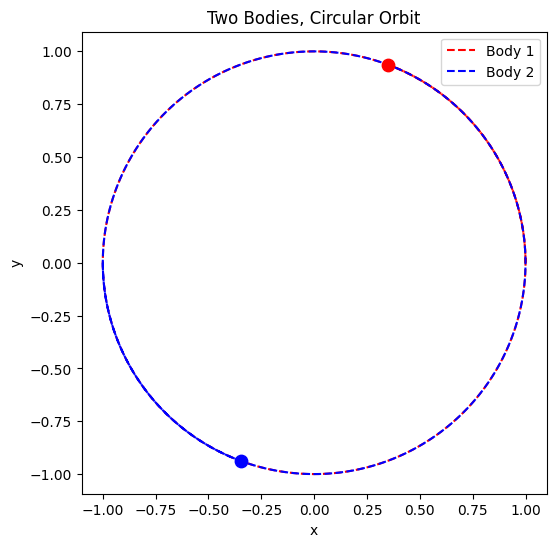

In [6]:
## Two Bodies in a circle.

# Initial conditions for each body.
m = [1.0, 1.0]
r0 = [[1.0, 0.0], [-1.0, 0.0]]
v0 = [[0.0, 0.5], [0.0, -0.5]]

# Solve the problem.
t_pts = np.arange(0, 15, 0.001)
r, v = leapfrog_solve(r0, v0, m, t_pts, G=1.0, eps=1e-3)

# Plot the results.
plot_orbits("Two Bodies, Circular Orbit", r)

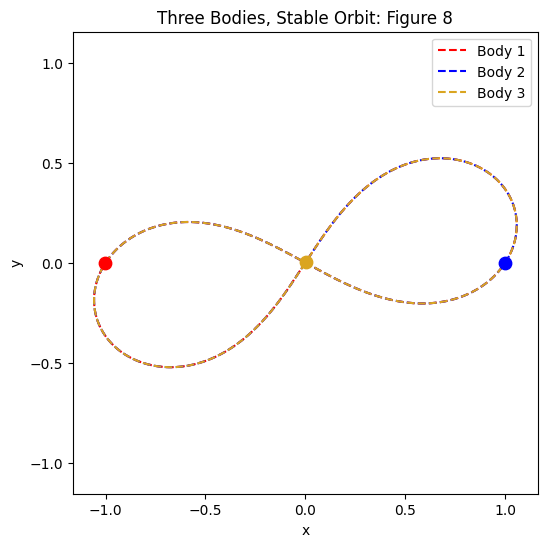

In [7]:
## Three Bodies in a Stable Orbit

# Initial conditions for each body.
m = [1.0, 1.0, 1.0]
r0 = [[-1, 0], [1, 0], [0, 0]]
v0 = [[0.347111, 0.532728], [0.347111, 0.532728], [-0.694222, -1.065456]]

# Solve the problem.
t_pts = np.arange(0, 6.324449, 0.001)
r, v = leapfrog_solve(r0, v0, m, t_pts, G=1.0, eps=1e-3)

# Plot the results.
plot_orbits("Three Bodies, Stable Orbit: Figure 8", r)

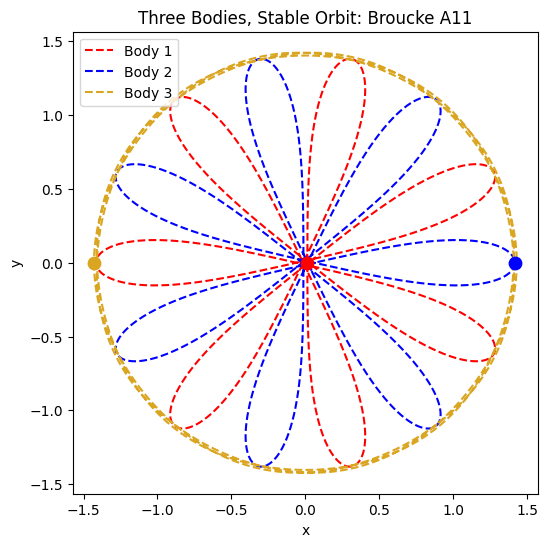

In [8]:
## Three Bodies in a Stable Orbit. Broucke A11.

# Initial conditions for each body.
m = [1.0, 1.0, 1.0]
r0 = [[0.0132604844, 0], [1.4157286016, 0], [-1.4289890859, 0]]
v0 = [[0, 1.054151921], [0, -0.2101466639], [0, -0.8440052572]]

# Solve the problem for one period.
t_pts = np.arange(0, 32.584945, 0.001)
r, v = leapfrog_solve(r0, v0, m, t_pts, G=1.0, eps=1e-3)

# Plot the results.
plot_orbits("Three Bodies, Stable Orbit: Broucke A11", r)

### B. Vector Field Plots

VECTOR FIELD PLOTS

---

## 3. Github Submission

The project repository can be found at the following link:

https://github.com/Xander-Carroll/PHYSICS5300-NBody-Final

---

## 6. Animations

The repository contains python scripts which use the `manim` library to plot orbits given several different sets of initial conditions. These are those animations.

<br/>

<video width="960" height="540" controls><source src="media/videos/1080p60/three-body.mp4" type="video/mp4"></video>

<br/>

<video width="960" height="540" controls><source src="media/videos/1080p60/solar-system.mp4" type="video/mp4"></video>

<br/>

<video width="960" height="540" controls><source src="media/videos/1080p60/solar-system-with-belt-100.mp4" type="video/mp4"></video>

---

## 8. Markdown Documentation

This notebook acts as a self-contained lesson. See the previous sections for details on how the solution was implemented.

---

## 9. Presentation

This project was presented in class on *12/9/25*. The presentation slides and notes are included in the project repository. 

The `*.pptx` file contains speaker notes with a summary of the talking points from the presentation.

---

## References

- https://github.com/neozhaoliang/pywonderland 
  - The inital conditions for the periodic solutions to the three-body problem were taken from this repository. 